# Homework 7

**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, March 9th, 2018 at 11:00am

# CASEY MEEHAN

**Instructions:**

- Upload your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

In [2]:
import numpy as np
from matplotlib import pyplot as plt

## Problem 1: Gibbs Sampling On A Bivariate Normal

Let $\mathbf{X}$ be a random variable taking values in $\mathbb{R}^2$. That is, $\mathbf{X}$ is a 2-dimensional vector. Suppose that $\mathbf{X}$ is normally distributed as follows
$$ 
\mathbf{X} \sim \mathcal{N} \left(  
\left[
\begin{array}{c}
    1  \\ 
    2  \\ 
  \end{array} 
\right],
\left[
  \begin{array}{ccc}
    4 & 1.2  \\ 
    1.2 & 4 \\ 
  \end{array} 
  \right] \right).
$$ 
That is, the pdf of the distribution of $\mathbf{X}$ is
$$
f_{\mathbf{X}}(\mathbf{x}) = \frac{1}{2\pi\sqrt{\vert \Sigma\vert }}\mathrm{exp}\left\{ - \frac{1}{2} (\mathbf{x} - \mu)^\top \Sigma^{-1} (\mathbf{x} - \mu)\right\}
$$
where $\mu = \left[
\begin{array}{c}
    1  \\ 
    2  \\ 
  \end{array} 
\right]$, $\Sigma = \left[
  \begin{array}{ccc}
    4 & 1.2  \\ 
    1.2 & 4 \\ 
  \end{array} 
  \right]$, and $\vert \cdot\vert $ is the matrix determinant operator.

In the following, we will denote the random variable corresponding to the first component of $\mathbf{X}$ by $X_1$ and the second component by $X_2$.

* Write a Gibbs sampler for this distribution by sampling sequentially from the two conditional distributions $f_{X_1\vert X_2}, f_{X_2\vert X_1}$. 
* Choose a thinning parameter, burn-in factor and total number of iterations that allow you to take 10000 non-autocorrelated draws. 
* You must justify your choice of parameters. 

## 1a) Choose a thinning parameter, burn-in factor and total number of iterations that allow you to take 10000 non-autocorrelated draws. You must justify your choice of parameters.

See derivation and code below: 

Ultimately used a burn-in of 100, and thinning factor of 10. As can be seen in the plots below, the burn-in is sufficient to settle the trace plot (even when starting from 0) and the thinning leaves little to no autocorrelation between samples. The total number of iterations is simply the number of samples (10000) times the burn-in factor: ($10000 \times 10 = 1e5$) 

## First, find conditional densities: 

For a bivariate normal with the joint density defined by parameters  
$$
\mu = 
\begin{pmatrix}
\mu_1 \\
\mu_2
\end{pmatrix}, ~
\Sigma = 
\begin{pmatrix} 
\sigma_{11}^2 & \sigma_{12}^2 \\
\sigma_{21}^2 & \sigma_{22}^2 
\end{pmatrix}
$$
We know that the conditional is given by $p(x_1 | x_2) = \mathbb{N}(\mu_{1|2}, \sigma^2_{1|2})$, where the mean and variance are 
$$
\mu_{1|2} = \mu_1 + \frac{\sigma_{12}^2}{\sigma_{22}^2} (x_2 - \mu_2) \\
\sigma_{1|2}^2 = \sigma_{11}^2 - \frac{\sigma_{12}^2\sigma_{21}^2}{\sigma_{22}^2}
$$
and vice-versa for $p(x_2 | x_1)$. This leads to parameters: 
$$
\mu_{1|2} = 1 + \frac{1.2}{4} (x_2 - 2), ~\sigma_{1|2}^2 = 4 - \frac{1.2^2}{4} = 3.64, ~\sigma_{1|2} = 1.908 \\
\mu_{2|1} = 2 + \frac{1.2}{4} (x_1 - 1), ~\sigma_{2|1}^2 = 4 - \frac{1.2^2}{4} = 3.64, ~\sigma_{2|1} = 1.908
$$

## Then, write Gibbs sampler (borrowed from lab) 

In [4]:
#Gibbs sampler: 

#First make conditional samplers 
def x1_given_x2(x2): 
    mu_x12 = 1 + 0.3*(x2 - 2)
    return np.random.normal(mu_x12, 1.908)

def x2_given_x1(x1): 
    mu_x21 = 2 + 0.3*(x1 - 1)
    return np.random.normal(mu_x21, 1.908)

#Then function to run gibb's sampler 
def gibbs(xgiveny_sample, ygivenx_sample, N, start = [0,0]):
    x=start[0]
    y=start[1]
    samples=np.zeros((N+1, 2))
    samples[0,0]=x
    samples[0,1]=y
    
    for i in range(1,N,2):
        x=xgiveny_sample(y)
        samples[i,0]=x
        samples[i, 1]=y
        
        y=ygivenx_sample(x)
        samples[i+1,0]=x
        samples[i+1,1]=y
        
    return samples

## Add burn-in and thinning and check autocorrelation

In [5]:
#Augmented gibbs with burn-in and thinning: 

#Then function to run gibb's sampler 
def gibbs_pp(xgiveny_sample, ygivenx_sample, N,  burn_in, thin_fac, start = [0,0]):
    tot_samples = burn_in + N*thin_fac
    raw_samps = gibbs(xgiveny_sample, ygivenx_sample, tot_samples, start)
    post_burn = raw_samps[burn_in+1:,:]
    post_thin = post_burn[0::thin_fac, :]
    return post_thin 

#Function to see autocorrelation of a given dimension (x1 or x2)
#useful for checking thinning
def corrplot(trace, maxlags=50):
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])
    

In [6]:
#Generate samples with burn-in 100, thinning 10 
samps = gibbs_pp(x1_given_x2, x2_given_x1, 10000, 100, 10)

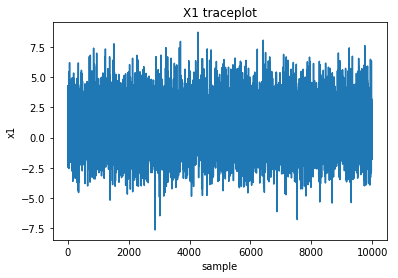

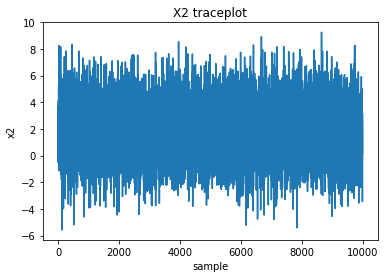

In [7]:
#Check trace (to see if burn-in is sufficient)
plt.plot(samps[:,0])
plt.xlabel('sample') 
plt.ylabel('x1')
plt.title('X1 traceplot')
plt.show()

plt.plot(samps[:,1])
plt.xlabel('sample') 
plt.ylabel('x2')
plt.title('X2 traceplot')
plt.show()

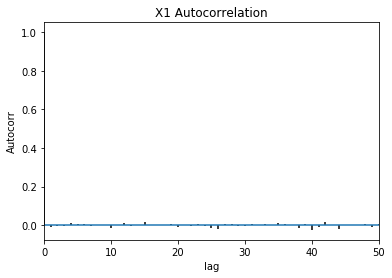

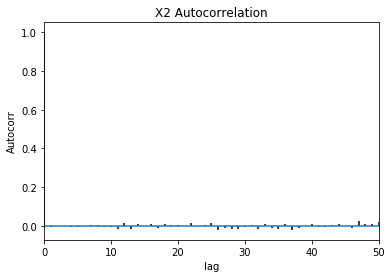

In [8]:
#Generate correlation plot
corrplot(samps[:,0])
plt.xlabel('lag')
plt.ylabel('Autocorr')
plt.title('X1 Autocorrelation')
plt.show()

corrplot(samps[:,1])
plt.xlabel('lag')
plt.ylabel('Autocorr')
plt.title('X2 Autocorrelation')
plt.show()

## Problem 2: Rubber Chickens Bawk Bawk!
In the competitive rubber chicken retail market, the success of a company is built on satisfying the exacting standards of a consumer base with refined and discriminating taste. In particular, customer product reviews are all important. But how should we judge the quality of a product based on customer reviews?

On Amazon, the first customer review statistic displayed for a product is the ***average rating***. The following are the main product pages for two competing rubber chicken products, manufactured by Lotus World and Toysmith respectively:


Lotus World |  Toysmith
- |  - 
![alt](https://am207.github.io/2018spring/homework/lotus1.png) |  ![alt](https://am207.github.io/2018spring/homework/toysmith1.png)

Clicking on the 'customer review' link on the product pages takes us to a detailed break-down of the reviews. In particular, we can now see the number of times a product is rated a given rating (between 1 and 5 stars).

Lotus World |  Toysmith
- |  - 
![alt](https://am207.github.io/2018spring/homework/lotus2.png) |  ![alt](https://am207.github.io/2018spring/homework/toysmith2.png)

(The images above are also included on canvas in case you are offline, see below)

In the following, we will ask you to compare these two products using the various rating statistics. **Larger versions of the images are available in the data set accompanying this notebook**.

Suppose that for each product, we can model the probability of the value each new rating as the following vector:
$$
\theta = [\theta_1, \theta_2, \theta_3, \theta_4, \theta_5]
$$
where $\theta_i$ is the probability that a given customer will give the product $i$ number of stars.


### Part A: Inference

1. Suppose you are told that customer opinions are very polarized in the retail world of rubber chickens, that is, most reviews will be 5 stars or 1 stars (with little middle ground). Choose an appropriate Dirichlet prior for $\theta$. Recall that the Dirichlet pdf is given by:
$$
f_{\Theta}(\theta) = \frac{1}{B(\alpha)} \prod_{i=1}^k \theta_i^{\alpha_i - 1}, \quad B(\alpha) = \frac{\prod_{i=1}^k\Gamma(\alpha_i)}{\Gamma\left(\sum_{i=1}^k\alpha_i\right)},
$$
where $\theta_i \in (0, 1)$ and $\sum_{i=1}^k \theta_i = 1$, $\alpha_i > 0 $ for $i = 1, \ldots, k$.

2. Write an expression for the posterior pdf, using a using a multinomial model for observed ratings. Recall that the multinomial pdf is given by:
$$
f_{\mathbf{X}\vert  \Theta}(\mathbf{x}) = \frac{n!}{x_1! \ldots x_k!} \theta_1^{x_1} \ldots \theta_k^{x_k}
$$
where $n$ is the total number of trials, $\theta_i$ is the probability of event $i$ and $\sum_i \theta_i = 1$, and $x_i$ is count of outcome $i$ and $\sum_i x_i = n$. 

  **Note:** The data you will need in order to define the likelihood function should be read off the image files included in the dataset.
  

3. Sample 1,000 values of $\theta$ from the *posterior distribution*.
 
4. Sample 1,000 values of $x$ from the *posterior predictive distribution*.


### Part B: Ranking

1. Name at least two major potential problems with using only the average customer ratings to compare products.

  (**Hint:** if product 1 has a higher average rating than product 2, can we conclude that product 1 is better liked? If product 1 and product 2 have the same average rating, can we conclude that they are equally good?)
  

2. Using the samples from your *posterior distribution*, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.

3. Using the samples from your *posterior predictive distribution*, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.

4. Finally, which rubber chicken product is superior?

  (**Note:** we're not looking for "the correct answer" here, any sound decision based on a statistically correct interpretation of your model will be fine)

# Part A1) Choose an appropriate Dirichlet prior for  θ

We want to choose a prior that reflects this belief that users will go mostly 5-star or 1-star. As such, our prior should put a lot of weight on $\theta_1$ and $\theta_5$ and little weight on $\theta_2, \theta_3, \theta_4$. Choose the prior: 
$$
\alpha_{1, \dots, 5} = [120, 1, 1, 1, 120]
$$

# Part A2) Write an expression for the posterior pdf

The posterior pdf can be found by: 
\begin{align}
p(\theta | D) = \frac{p(D|\theta)p(\theta)}{p(D)} &\propto p(D|\theta)p(\theta) \\
&= \left( \prod_{i=1}^n f_{\mathbf{X}\vert  \Theta}(\mathbf{x}_i) \right) f_{\Theta}(\theta) \\
&\propto \prod_{i=1}^K \theta_i^{\alpha_i - 1 + \sum_{j=1}^n \mathbf{1}_{x_j = i}}
\end{align}
Which is a dirichlet distribution on $\theta$ with pseudocounts from the data: 
$$
p(\theta | D) = \text{Dir}(\alpha_{1, \dots, 5}')
$$
where $\alpha_i' = \alpha_i + \sum_{j=1}^n \mathbf{1}_{x_i = i}$ 

For Lofta's that becomes: 
\begin{align}
\alpha_5' &= 120 + 0.67\times162 = 228.54 \\
\alpha_4' &= 1 + 0.17\times162 = 28.54 \\
\alpha_3' &= 1 + 0.06\times162 = 10.72 \\
\alpha_2' &= 1 + 0.04\times162 = 7.48 \\
\alpha_1' &= 120 + 0.06\times162 = 129.72 \\
\end{align}

For Toysmith that becomes: 
\begin{align}
\alpha_5' &= 120 + 0.60\times410 = 366 \\
\alpha_4' &= 1 + 0.11\times410 = 46.1 \\
\alpha_3' &= 1 + 0.07\times410 = 29.7 \\
\alpha_2' &= 1 + 0.08\times410 = 33.8 \\
\alpha_1' &= 120 + 0.14\times410 = 177.4 \\
\end{align}

Additionally, compute the posterior predictive ($D_n$ are the previous $n$ data points): 
\begin{align}
    p(x_{n+1}=k | D_n, \alpha) &= \int p(x_{n+1}=k | \theta) p(\theta | D_n, \alpha) d\theta \\
    &= \int \theta_k \text{Dir}(\alpha_{1,...,k}') d\theta \\
    &= \frac{\alpha_k'}{\sum_{i=1}^K \alpha_i'}
\end{align}

# Part A3) Sample 1,000 values of $\theta$ from the *posterior distribution*.

In [33]:
#Sample theta from posterior by sampling from Dir(alpha')
def samp_loftas(N): 
    alpha = np.array([129.72, 7.48, 10.72, 28.54, 228.54])
    return np.random.dirichlet(alpha, N)

def samp_toysmith(N): 
    alpha = np.array([177.4, 33.8, 29.7, 46.1, 366])
    return np.random.dirichlet(alpha, N)

In [34]:
#Generate 1000 samples of each: 
thet_loftas_samps = samp_loftas(1000)
thet_toysmith_samps = samp_toysmith(1000)

#Get average thetas: 
thet_loftas_ave = np.sum(thet_loftas_samps, 0) / 1000
thet_toysmith_ave = np.sum(thet_toysmith_samps, 0) / 1000

print('loftas thet ave', thet_loftas_ave)
print('loftas ave', np.mean(thet_loftas_ave.dot(np.arange(1,6))))
print('toysmith thet ave', thet_toysmith_ave)
print('toysmith ave', np.mean(thet_toysmith_ave.dot(np.arange(1,6))))

loftas thet ave [ 0.32112752  0.01808789  0.02636335  0.07003636  0.56438487]
loftas ave 3.53846317118
toysmith thet ave [ 0.27153104  0.05197886  0.04555887  0.07000924  0.56092198]
toysmith ave 3.59681225358


# Part A4) Sample 1,000 values of $x$ from the *posterior predictive distribution*.

In [39]:
#Sample x from posterior predictive for each of the two products: 

def predict_loftas(N): 
    alpha = np.array([129.72, 7.48, 10.72, 28.54, 228.54])
    alpha_norm = alpha / np.sum(alpha)
    return np.random.choice(np.arange(1,6), size=N, p=alpha_norm)

def predict_toysmith(N): 
    alpha = np.array([177.4, 33.8, 29.7, 46.1, 366])
    alpha_norm = alpha / np.sum(alpha)
    return np.random.choice(np.arange(1,6), size=N, p=alpha_norm)

In [40]:
N = 1000
samps = predict_toysmith(N)
p5 = np.sum(samps == 5) / N
p4 = np.sum(samps == 4) / N
p1 = np.sum(samps == 1) / N
print('p5', p5)
print('p4', p4)
print('p1', p1)
# alpha = np.array([29.72, 7.48, 10.72, 28.54, 128.54])
alpha = np.array([77.4, 33.8, 29.7, 46.1, 266])
alpha_norm = alpha / np.sum(alpha)
print('alph', alpha_norm)

p5 0.541
p4 0.072
p1 0.278
alph [ 0.17086093  0.07461369  0.06556291  0.101766    0.58719647]


# Part B1) Name at least two major potential problems with using only the average customer ratings to compare products.

1) Using only average customer ratings is purely frequentist and does not include any prior knowledge of how people add reviews. Even though the average favors loftas over toysmith, it is possible to have a posterior that would favor toysmith over loftas depending on one's prior on how individuals leave reviews. 

2) One product (loftas) has substantially fewer reviews than the other. Fewer reviews imlpies higher variance of the sample mean estimator. As such, it's not an apples to apples comparison. 

# Part B2) Using the samples from your posterior distribution, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.

Here I generated 1000 samples of $\theta$ from the posterior of each Loftas and Toysmith. I then took the average the average $\theta$, $\widehat{\theta}$, and found the expected product score 
$$
S = \sum_{i=1}^5 \widehat{\theta}_i i
$$
I claim, whichever has a higher posterior $S$ is superior. Unlike the average rating, Toysmith has a higher posterior rating ($S$), 3.597 to 3.538

In [36]:
#Generate 1000 samples of each: 
thet_loftas_samps = samp_loftas(1000)
thet_toysmith_samps = samp_toysmith(1000)

#Get average thetas: 
thet_loftas_ave = np.sum(thet_loftas_samps, 0) / 1000
thet_toysmith_ave = np.sum(thet_toysmith_samps, 0) / 1000

print('loftas thet ave', thet_loftas_ave)
print('loftas ave', np.mean(thet_loftas_ave.dot(np.arange(1,6))))
print('toysmith thet ave', thet_toysmith_ave)
print('toysmith ave', np.mean(thet_toysmith_ave.dot(np.arange(1,6))))

loftas thet ave [ 0.32042622  0.01830751  0.02628897  0.070332    0.56464531]
loftas ave 3.54046268248
toysmith thet ave [ 0.27310337  0.05159902  0.04547586  0.07054481  0.55927695]
toysmith ave 3.59129293149


# Part B3) Using the samples from your *posterior predictive distribution*, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.

I generated 1000 samples (ratings) from each posterior predictive, and found the sample mean of each. Ultimately, toysmith has a higher rating (3.592 to 3.46), unlike the average ratings score. 

In [42]:
N = 1000
loftas_preds = predict_loftas(N)
loftas_ave = np.mean(loftas_preds)
toysmith_preds = predict_toysmith(N)
toysmith_ave = np.mean(toysmith_preds)

print('average loftas', loftas_ave)
print('average toysmith', toysmith_ave)

average loftas 3.46
average toysmith 3.592


# Part B4) Finally, which rubber chicken product is superior?

Given that the estimated posterior parameter ($\theta$) and average posterior predictive score ($x$) both point to toysmith having a higher score, I will say that toysmith has the better product. This is counter to what the average rating suggests. 

However, this highly dependent on my (relatively strong) prior. In a sense, the prior is still overwhelming the likelihood. It is possible that with more ratings, the data would overwhelm this prior and again suggest that Loftas has the better product. 

## Problem 3:  Implementing Rat Tumors in pymc3

(it may help to see the bioassay lab to see how to structure pymc3 code, and also the examples from lecture).

Let us try to do full Bayesian inference with PyMC3 for the rat tumor example that we have solved using explicit Gibbs sampling in lab7. Remember that the goal is to estimate $\theta_i$, the probability of developing a tumor in a population of female rats that have not received treatement. 

The posterior for the 70 experiments may be written thus:

$$p( \{\theta_i\}, \alpha, \beta  \vert  Y, \{n_i\}) \propto p(\alpha, \beta) \prod_{i=1}^{70} Beta(\theta_i, \alpha, \beta) \prod_{i=1}^{70} Binom(n_i, y_i, \theta_i)$$

Use uniform priors on $[0,1]$ on the alternative variables $\mu$ (the mean of the beta distribution) and $\nu$:

$$\mu = \frac{\alpha}{\alpha+\beta}, \nu = (\alpha+\beta)^{-1/2}$$

You may then write $\alpha$ and $\beta$ as deterministics which depend on $\mu$ and $\nu$.

Here is the data:

In [3]:
tumordata="""0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 19 
0 19 
0 19 
0 19 
0 18 
0 18 
0 17 
1 20 
1 20 
1 20 
1 20 
1 19 
1 19 
1 18 
1 18 
3 27 
2 25 
2 24 
2 23 
2 20 
2 20 
2 20 
2 20 
2 20 
2 20 
1 10 
5 49 
2 19 
5 46 
2 17 
7 49 
7 47 
3 20 
3 20 
2 13 
9 48 
10 50 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
10 48 
4 19 
4 19 
4 19 
5 22 
11 46 
12 49 
5 20 
5 20 
6 23 
5 19 
6 22 
6 20 
6 20 
6 20 
16 52 
15 46 
15 47 
9 24 
"""

# Problem 3)  estimate  $\theta_i$, the probability of developing a tumor in a population of female rats that have not received treatement

In [4]:
tumortuples=[e.strip().split() for e in tumordata.split("\n")]
tumory=np.array([np.int(e[0].strip()) for e in tumortuples if len(e) > 0])
tumorn=np.array([np.int(e[1].strip()) for e in tumortuples if len(e) > 0])
print(tumory, tumorn)
print(np.shape(tumory))

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  3  2  2
  2  2  2  2  2  2  2  1  5  2  5  2  7  7  3  3  2  9 10  4  4  4  4  4  4
  4 10  4  4  4  5 11 12  5  5  6  5  6  6  6  6 16 15 15  9] [20 20 20 20 20 20 20 19 19 19 19 18 18 17 20 20 20 20 19 19 18 18 27 25 24
 23 20 20 20 20 20 20 10 49 19 46 17 49 47 20 20 13 48 50 20 20 20 20 20 20
 20 48 19 19 19 22 46 49 20 20 23 19 22 20 20 20 52 46 47 24]
(70,)


In [5]:
# pymc3
import pymc3 as pm
from pymc3 import Uniform, Normal, Binomial, Beta, sample, Model # Import relevant distributions

N = tumorn.shape[0]

with Model() as tumor_model:

    # Uniform priors on the mean and variance of the Beta distributions
    mu = Uniform("mu",0.00001,1.)
    nu = Uniform("nu",0.00001,1.)

    # Calculate hyperparameters alpha and beta as a function of mu and nu
    alpha = pm.Deterministic('alpha', mu/(nu*nu))
    beta = pm.Deterministic('beta', (1.-mu)/(nu*nu))
    
    # Priors for each theta
    thetas = Beta('theta', alpha, beta, shape=N)
    
    # Data likelihood
    obs_deaths = Binomial('obs_deaths', n=tumorn, p=thetas, observed=tumory)

In [132]:
with tumor_model:
    fit = pm.variational.inference.fit(n=100000)
    tumor_trace = pm.variational.approximations.sample_approx(fit, draws=50000)

Average Loss = 163.2: 100%|██████████| 100000/100000 [00:28<00:00, 3490.30it/s]
Finished [100%]: Average Loss = 163.19


### Part A:  Report at least the following diagostics on your samples

1. Autocorrelation (correlation dying by lag 20 is fine)
2. Parameter trace correlation after burnin
3. Gewecke
4. Gelman-Rubin
5. $n_{eff}$ (Number of Effective Samples)

## PartA1) Autocorrelation (correlation dying by lag 20 is fine)
(Producing autocorrelation of alpha and beta )

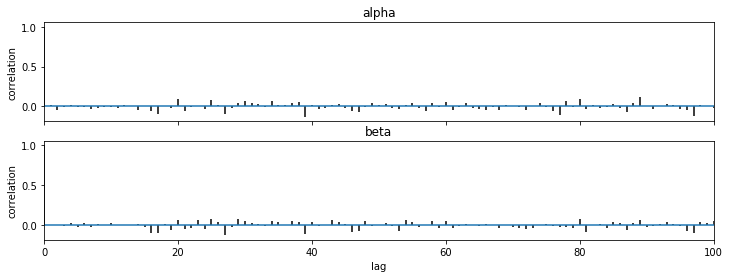

In [103]:
pm.autocorrplot(tumor_trace[2500::100],varnames=['alpha','beta'])
plt.show()

# Part A2. Parameter trace correlation after burnin

In [102]:
df = pm.trace_to_dataframe(tumor_trace)
df.corr()

,mu,nu,alpha,beta,theta__0,theta__1,theta__2,theta__3,theta__4,theta__5,...,theta__60,theta__61,theta__62,theta__63,theta__64,theta__65,theta__66,theta__67,theta__68,theta__69
mu,1.000000,-0.003270,0.411522,-0.073769,0.001324,0.000039,-0.004573,-0.002127,0.005384,-0.001301,...,-0.000675,-0.002151,0.000059,-0.005668,0.000355,0.003538,0.006185,0.005608,-0.001331,0.004407
nu,-0.003270,1.000000,-0.895020,-0.980604,0.002830,-0.002316,0.003372,0.001765,-0.003494,0.000588,...,-0.002743,-0.002368,0.002264,0.003299,0.000600,-0.005246,0.005180,-0.009184,-0.000980,-0.002390
alpha,0.411522,-0.895020,1.000000,0.874713,-0.001610,0.001915,-0.004746,-0.003056,0.005961,-0.001090,...,0.001750,-0.000442,-0.001569,-0.005344,0.000690,0.006783,-0.002621,0.010289,0.000032,0.004468
beta,-0.073769,-0.980604,0.874713,1.000000,-0.003399,0.001400,-0.003013,-0.002011,0.003519,-0.000042,...,0.002368,0.001373,-0.001846,-0.002810,0.000125,0.005548,-0.006335,0.008604,-0.000033,0.002794
theta__0,0.001324,0.002830,-0.001610,-0.003399,1.000000,-0.002230,-0.004267,-0.000020,0.003983,-0.001224,...,0.005093,0.006115,0.004862,-0.002109,0.002930,0.006222,0.006220,-0.005882,-0.002875,0.004026
theta__1,0.000039,-0.002316,0.001915,0.001400,-0.002230,1.000000,0.002157,0.000461,0.001303,0.002310,...,-0.002434,0.000886,-0.000649,0.001319,0.004832,0.002365,0.000383,0.001932,0.003060,0.004277
theta__2,-0.004573,0.003372,-0.004746,-0.003013,-0.004267,0.002157,1.000000,0.002503,0.003160,-0.001497,...,-0.002535,-0.004962,0.000697,-0.007286,-0.005123,0.003811,0.004064,-0.000898,0.000045,0.001316
theta__3,-0.002127,0.001765,-0.003056,-0.002011,-0.000020,0.000461,0.002503,1.000000,-0.008520,-0.000543,...,-0.002062,-0.002173,-0.002138,-0.007569,0.004649,-0.003321,-0.003186,-0.000646,0.002768,0.002857
theta__4,0.005384,-0.003494,0.005961,0.003519,0.003983,0.001303,0.003160,-0.008520,1.000000,-0.008524,...,-0.000391,0.006392,0.002214,0.000218,0.000098,-0.000468,0.006332,-0.000310,-0.001103,0.006793
theta__5,-0.001301,0.000588,-0.001090,-0.000042,-0.001224,0.002310,-0.001497,-0.000543,-0.008524,1.000000,...,-0.005313,0.005687,0.004911,-0.005547,-0.002253,-0.013139,-0.001294,0.000919,0.003764,-0.006134


## Part A3) Gewecke 

In [106]:
from pymc3 import geweke
    
z = geweke(tumor_trace, intervals=15)

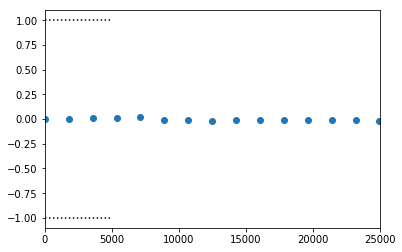

In [122]:
plt.scatter(z['alpha'][:,0], z['alpha'][:,1])
plt.hlines([-1,1], 0, 5000, linestyles='dotted')
plt.xlim(0, 25000)
plt.show()

# Gelman-Rubin

NOTE: Gelman-Rubin did not work. The statistic requires multiple chains to be produced, however it appeared that the multi-chain samplers used in lab (e.g. NUTS) are deprecated, and we had trouble producing multiple chains. (intuitively, we should be able to produce multiple chains sequentially and merge them after, but pymc3 does not provide any easy way to do that...) 

If we were able to produce multiple chains, Gelman-Rubin would describe between-chain variance relative to within-chain variance. The idea being that if within-chain variance is similar to between-chain variance, we can be comfortable that we've achieved convergence. 

In [203]:
from pymc3 import gelman_rubin

gelman_rubin(np.array(tumor_trace))

IndexError: tuple index out of range

# Part 5) $n_{eff}$ (Number of Effective Samples)

Similar to Gelman-Rubin, the n_eff statistic requires multiple chains, and we had trouble finding a sampler that produces multiple chains. 

If it worked, $n_{eff}$ should tell us about autocorrelation. If there is a high degree of autocorrelation, it's as if our sample size from a particular distribution is lower than the number of times we actually sampled. 

In [136]:
pm.effective_n(tumor_trace)

ValueError: Calculation of effective sample size requires multiple chains of the same length.

### Part B:  Posterior predictive check

Recall from lab notes that in a hierarchical model there are two kinds of posterior predictions that are useful. (1) The distribution of future observations $y_i^*$  given a $\theta_i$, and (2) The distribution of observations $y_j^*$  drawn from a future $\theta_j$ drawn from the super-population (i.e. using the Beta on the estimated hyper parameters).

1. Carry out posterior predictive checks by using `sample_ppc` to generate posterior-predictives for all 70 experiments. This generates predictives of the first type above. 

2. Plot histograms for these predictives with the actual value shown as a red-dot against the histogram (as in the coal disasters model in lecture 14). Is the data consistent with the predictive?

# Part B1) Carry out posterior predictive checks by using `sample_ppc` to generate posterior-predictives for all 70 experiments. This generates predictives of the first type above. 

In [137]:
from pymc3 import sample_ppc
with tumor_model:
    tumor_sim = sample_ppc(tumor_trace[500:], samples=500)

100%|██████████| 500/500 [00:00<00:00, 4037.08it/s]


# Part B2)  Plot histograms for these predictives with the actual value shown as a red-dot against the histogram (as in the coal disasters model in lecture 14). Is the data consistent with the predictive?

Given the histograms and actual $y$'s, the actual values appear at least qualitatively consitent with the predictive. 

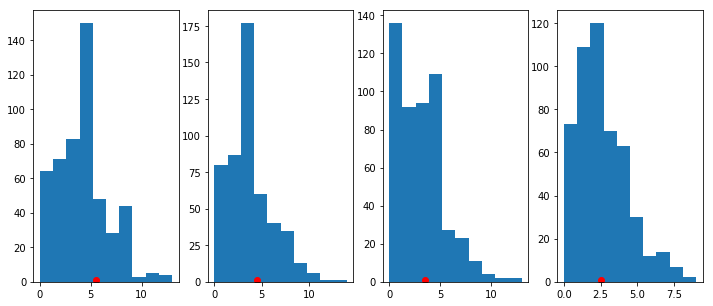

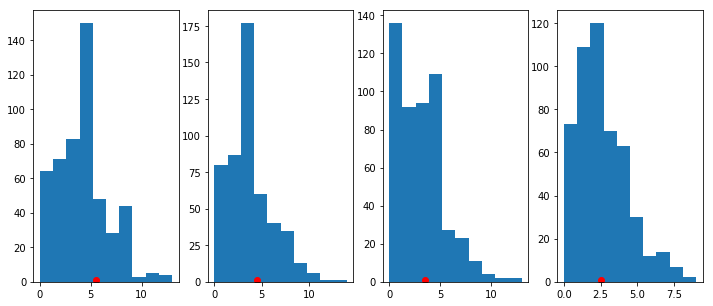

In [140]:
fig = plt.subplots(1, 4, figsize=(12, 5))
plt.subplot(1,4,1)
plt.hist(tumor_sim['obs_deaths'].T[59])
plt.plot(tumory[59]+0.5, 1, 'ro')
plt.subplot(1,4,2)
plt.hist(tumor_sim['obs_deaths'].T[49])
plt.plot(tumory[49]+0.5, 1, 'ro')
plt.subplot(1,4,3)
plt.hist(tumor_sim['obs_deaths'].T[39])
plt.plot(tumory[39]+0.5, 1, 'ro')
plt.subplot(1,4,4)
plt.hist(tumor_sim['obs_deaths'].T[29])
plt.plot(tumory[29]+0.5, 1, 'ro')
plt.show()

### Part C:  Shrinkage

1. Plot the posterior median of the death rate parameters $\theta_1, \theta_2, ...\theta_{70}$ against the observed death rates ($y_i/n_i$)

2. Explain the shrinkage by comparing against a 45 degree line as done in the lab.

The range of the posterior median is less than the the range of the observed rates. This is because the posterior median is regularized by the prior. 

/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: df_summary has been deprecated. In future, use summary instead.
  This is separate from the ipykernel package so we can avoid doing imports until


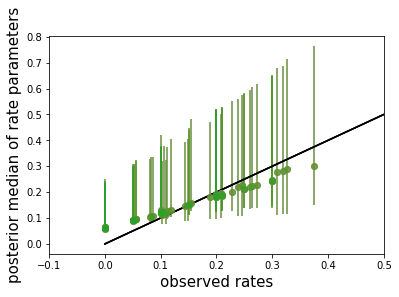

In [143]:
from pymc3 import df_summary

df_sum = df_summary(tumor_trace[500:], varnames=['theta'])
medianthetas = df_sum['mean'].values
lowerthetas = df_sum['hpd_2.5'].values
upperthetas = df_sum['hpd_97.5'].values

elowertheta = medianthetas - lowerthetas
euppertheta = upperthetas - medianthetas

ratios=tumory.astype(float)/tumorn

plt.errorbar(ratios, 
             medianthetas, yerr=[lowerthetas,upperthetas], fmt='o', alpha=0.5)
plt.plot([0,0.5],[0,0.5],'k-')
plt.xlabel("observed rates",size=15)
plt.ylabel("posterior median of rate parameters",size=15)

plt.xlim(-0.1,0.5)
plt.show()

### PART D:  Experiment 71

Consider an additional experiment -- experiment 71 -- in which 4 out of 14 rats died. 

1. Calculate the marginal posterior of $\theta_{71}$, the "new" experiment,

2. Find the $y_{71}^*$ posterior predictive for that experiment.

**HINT: ** The critical thing to notice is that the posterior including the 71st experiment factorizes:

$$p(\theta_{71}, \theta_{1..70}, \alpha, \beta \vert  D)  \propto p(y_{71} \vert n_{71}, \theta_{71} ) p(\theta_{71} \vert \alpha, \beta) p(\theta_{1..70}, \alpha, \beta \vert  D)$$

Then we simply marginalize over everything to get the $\theta_{71}$ posterior:

$$p(\theta_{71} \vert \theta_{1..70}, \alpha, \beta, D) = \int d\alpha \,d\beta \,d\theta_{1..70} \,p(\theta_{71}, \theta_{1..70}, \alpha, \beta \vert  D)$$

$$=  \int d\alpha \,d\beta  Beta(\alpha+y_{71}, \beta + n_{71} - y_{71})  \int_{\theta_{1..70}} \,d\theta_{1..70} \,p(\theta_{1..70}, \alpha, \beta \vert  D)$$

The $y_{71}^*$ posterior predictive can be found in the usual way.

# Part C1) Calculate the marginal posterior of $\theta_{71}$, the "new" experiment,

### First, generate the average pdf using the conjugate prior updates ($\alpha + 4$, $\beta + 14-4$) 

In [199]:
from scipy import stats
p71=np.empty((1000,3000))
combpdf=np.zeros(1000)
xra=np.linspace(0.,1.,1000)
for i in range(3000):
    p71[:,i] = stats.beta.pdf(xra, tumor_trace['alpha'][500:][i]+4, tumor_trace['beta'][500:][i]+10)
for j in range(1000):
    combpdf[j] = combpdf[j] + p71[j,:].sum()
p71.shape, p71[2,:].shape

((1000, 3000), (3000,))

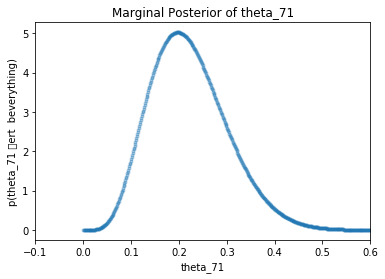

In [200]:
plt.plot(xra, combpdf/3000., '.', alpha=0.3)
plt.title('Marginal Posterior of theta_71')
plt.xlabel('theta_71')
plt.ylabel('p(theta_71 \vert  beverything)')
plt.xlim([-.1,.6])
plt.show()

### This can similarly be done by just taking the average $\alpha$ and $\beta$ and adding the posterior updates (same distribution results) 

alpha post: 5.79417687757
beta post 19.6069104557


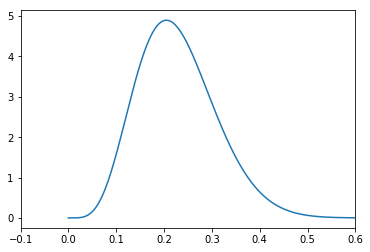

In [202]:
al_post = np.mean(tumor_trace['alpha'][500:])+4

be_post = np.mean(tumor_trace['beta'][500:][i])+10

dist_post = stats.beta.pdf(xra, al, be) 

plt.plot(xra, dist) 
print('alpha post:', al_post)
print('beta post', be_post)

plt.xlim([-.1,.6])
plt.show()

# Part 2. Find the $y_{71}^*$ posterior predictive for that experiment.

### Sample $\theta_{71}$ 50k times from beta($\alpha_{\text{post}}, \beta_{\text{post}}$) and each time produce a new sample of $y_{71}$. This marginalizes out $\theta_{71}$

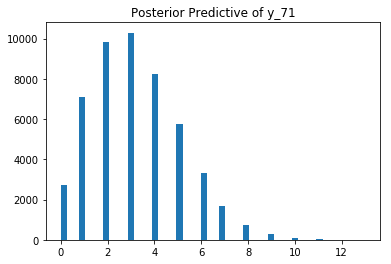

In [195]:
#Sample 50k posterior theta_71's 
posterior_theta_71 = np.random.beta(al_post, be_post,50000)

#To marginalize out theta, sample new y for each theta_71 
post_pred_y71 = np.zeros(50000)
for i in range(np.size(posterior_theta_71)): 
    post_pred_y71[i] = np.random.binomial(14, posterior_theta_71[i], size=1)

#Show distribution of y71: 
plt.hist(post_pred_y71, bins = 50)
plt.title('Posterior Predictive of y_71')
plt.show()